[Descripción y lineamientos del proyecto](https://docs.google.com/document/d/152L5VsLgPlLHH-Gz_93hOaG3J5BapcxNvHiXiYxhPdc/edit#heading=h.7092f8q9v51p)

# 1. Objetivo General:

*   Explorar noticias relacionadas con **la situación política y social de Colombia**, con el fin de **analizar y comprender la perspectiva, tanto local, como internacional sobre éste como un país con buenos planteamientos socioeconómicos desde el punto de vista del Derecho Internacional**, para el **Ministerio de Relaciones Exteriores de Colombia**



# 2. Recolección de datos

Para esta etapa, se utilizará la API de [newsapi.ai](https://newsapi.ai), la cual permite la recolección de noticias con cantidades superiores a otras API encontradas. Los parámetros de búsqueda implicarán los siguientes factores:


*   Categoría: Política.
*   Concepto: Colombia (esto únicamente en el caso internacional).
*   Tipo de artículos: Noticias, Blogs y Comunicados de prensa.
*   Palabras clave: Serán empleadas una gran variedad de palabras clave, que permitan recrear un panorama amplio sobre la actualidad política y temas sociales en Colombia, incluyendo temas económicos y referentes al derecho internacional.
*   Idiomas: Para las noticias locales, solo español, y en las internacionales se utilizará también el inglés para posteriormente traducirlas.
*   Rango de fechas: Desde el 4 de Junio al 13 de Julio de 2024.


[Documentación de la API utilizada para la obtención de datos](https://newsapi.ai/documentation?tab=introduction)

[Repositorio del paquete necesario para realizar consultas a la API (Event Registry)](https://github.com/EventRegistry/event-registry-python/wiki)

In [ ]:
!pip install python-dotenv
!pip install ydata-profiling
!pip install eventregistry
!pip install googletrans==3.1.0a0
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=956bf400a0b27c6dc8407703f04a32bab1e09ee24a8aa13aab14077b08243baf
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eventregistry: filename=eventregistry-9.1-py3-none-any.whl size=67624 sha256=40c10a325993f2e00166bea39b685238a33154abae1ce132a14ade882f20586c
  Stored in directory: /root/.cache/pip/wheels/43/b1/a3/96

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from dotenv import load_dotenv
from eventregistry import *
from google.colab import drive
from googletrans import Translator
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
from scipy.special import softmax

In [ ]:
# Los notebooks no permiten almacenar documentos en la sesión, por lo que
# el entorno será ejecutado desde el almacenamiento de Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if os.path.isdir("/content/drive/MyDrive/NewsAnalyzer"):
  env_src = '/content/drive/MyDrive/NewsAnalyzer/env.txt'
  load_dotenv(env_src)

  NEWS_API_KEY = os.getenv('NEWS_API_KEY')

In [ ]:
# Todas las palabras que estén comentadas significa que ya fueron utilizadas
# para buscar noticias relacionadas, para ampliar el dataframe se emplearán
# otras palabras también (la API tiene un límite de 15 palabras clave por búsqueda)

KEYWORDS_SPA = [
    'Colombia',
    'Colombiano',
    'Gobierno',
    'Estado',
    #'Petro',
    #'Uribe',
    'Muerte',
    'Ataque',
    #'Herido',
    'Victima',
    #'Activista',
    'Medio ambiente',
    'Trabajadores',
    'Salario',
    'Inversión',
    #'Inversionista',
    #'Pagos',
    'Derechos'
    #'Izquierda',
    #'Derecha',
    #'Comunismo',
    #'Socialismo',
    #'Democracia',
    #'Reformas',
    'Golpe de estado',
    'Tratado',
    'Radicalismo'
]

KEYWORDS_ENG = [
    'Colombia',
    #'Colombian',
    'Government',
    'State',
    'Party',
    #'Petro',
    #'Uribe',
    'Death',
    'Attack',
    'Victim',
    'Activist',
    'Environment',
    'Worker',
    'Salary',
    'Investment',
    'Investor',
    #'Payment',
    'Rights'
    #'Left',
    #'Right',
    #'Comunism',
    #'Democracy',
    'Reform'
]

In [ ]:
articles_col = []
articles_int = []

In [ ]:
er = EventRegistry(apiKey=NEWS_API_KEY, allowUseOfArchive=False)

In [ ]:
# Noticias de medios locales
# Para filtrar por noticias más relevantes según Alexa
# modificar el parámetro sortBy por 'sourceAlexaGlobalRank'

# get the Colombia URI
colUri = er.getLocationUri('Colombia')

q_col = QueryArticlesIter(
  categoryUri=er.getCategoryUri('politics'),
  keywords=QueryItems.OR(KEYWORDS_SPA),
  keywordsLoc='title',
  dateStart='2024-06-06',
  dateEnd='2024-07-05',
  lang='spa',
  #isDuplicateFilter="skipDuplicates",
  sourceLocationUri=colUri,
  dataType = ['news', 'blog', 'pr']
)

for art in q_col.execQuery(er, sortBy='socialScore'):
    articles_col.append(art)

In [ ]:
# Noticias de medios internacionales

q_int = QueryArticlesIter(
  conceptUri=er.getConceptUri('Colombia'),
  categoryUri=er.getCategoryUri('politics'),
  keywords=QueryItems.OR(KEYWORDS_ENG),
  keywordsLoc='title',
  dateStart='2024-06-06',
  dateEnd='2024-07-05',
  lang=['spa', 'eng'],
  #isDuplicateFilter="skipDuplicates",
  dataType = ['news', 'blog', 'pr']
)

for art in q_int.execQuery(er, sortBy='socialScore'):
    articles_int.append(art)

In [ ]:
articles_col[0]

{'uri': '8193252323',
 'lang': 'spa',
 'isDuplicate': False,
 'date': '2024-06-24',
 'time': '16:51:48',
 'dateTime': '2024-06-24T16:51:48Z',
 'dateTimePub': '2024-06-24T16:48:54Z',
 'dataType': 'news',
 'sim': 0.8274509906768799,
 'url': 'https://www.semana.com/politica/articulo/urgente-esta-es-la-prueba-reina-de-que-asofondos-le-redacto-la-proposicion-al-senador-gustavo-moreno-para-quedarse-con-billonarias-comisiones-que-pagaran-los-trabajadores/202424/',
 'title': 'Urgente: esta es la prueba reina de que Asofondos le redactó la proposición al senador Gustavo Moreno para quedarse con billonarias comisiones que pagarán los trabajadores',
 'body': '5. "Tuve la peor noche de mi vida, creí que no iba a contar la historia": dramático relato del concejal Julián Triana, herido en atraco\n\nEl 17 de abril, el senador Gustavo Moreno, elegido por la coalición de la Centro Esperanza y con el respaldo de En Marcha, radicó una polémica proposición en la plenaria del Senado que terminó beneficiand

In [ ]:
articles_int[0]

{'uri': '8175161497',
 'lang': 'spa',
 'isDuplicate': False,
 'date': '2024-06-13',
 'time': '01:39:51',
 'dateTime': '2024-06-13T01:39:51Z',
 'dateTimePub': '2024-06-13T01:39:24Z',
 'dataType': 'news',
 'sim': 0,
 'url': 'https://elpais.com/america-colombia/2024-06-13/el-congreso-de-colombia-hunde-de-nuevo-el-proyecto-que-buscaba-prohibir-las-terapias-de-conversion-sexual.html',
 'title': 'El Congreso de Colombia hunde de nuevo el proyecto que buscaba prohibir las terapias de conversión sexual',
 'body': 'El Congreso de Colombia ha dejado hundir este miércoles, por segunda vez consecutiva, un proyecto de ley que buscaba prohibir las terapias de conversión sexual para la comunidad LGBTIQ+. Esta decisión significa una negativa a garantizar los derechos para esta población y, al tiempo, confirma el superpoder político de las iglesias cristianas y los partidos conservadores, principales opositores de la iniciativa.\n\nEl proyecto, que había pasado con éxito los dos primeros debates en la 

In [ ]:
df_col = pd.DataFrame(articles_col)
df_int = pd.DataFrame(articles_int)

In [ ]:
df_col.head()

,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,source,authors,image,eventUri,sentiment,wgt,relevance
0,8193252323,spa,False,2024-06-24,16:51:48,2024-06-24T16:51:48Z,2024-06-24T16:48:54Z,news,0.827451,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"5. ""Tuve la peor noche de mi vida, creí que no...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/SZ7N4BDZLZAT...,spa-3525608,None,163,11
1,8202085699,spa,False,2024-06-29,23:43:08,2024-06-29T23:43:08Z,2024-06-29T23:42:58Z,news,0.572549,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...","5. ""Me dolió"": Néstor Lorenzo destapó verdad d...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/S74NQFRDBRAE...,spa-3530509,None,131,16
2,8189001343,spa,False,2024-06-21,15:22:41,2024-06-21T15:22:41Z,2024-06-21T15:20:47Z,news,0.650980,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,"También indicó: ""El debate actual en el senado...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/NESZLFHBJFFP...,spa-3519360,None,97,16
3,8197079866,spa,False,2024-06-26,19:35:27,2024-06-26T19:35:27Z,2024-06-26T19:34:03Z,news,0.674510,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,5. Una perla: polémica fiscal Angélica Monsalv...,"{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/LFM64U4S4VAK...,spa-3524372,None,85,9
4,8182148686,spa,False,2024-06-17,15:31:02,2024-06-17T15:31:02Z,2024-06-17T15:30:02Z,news,0.792157,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...","{'uri': 'las2orillas.co', 'dataType': 'news', ...","[{'uri': 'mas_colombia@las2orillas.co', 'name'...",https://www.las2orillas.co/wp-content/uploads/...,spa-3520229,None,79,13


In [ ]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uri          1207 non-null   object 
 1   lang         1207 non-null   object 
 2   isDuplicate  1207 non-null   bool   
 3   date         1207 non-null   object 
 4   time         1207 non-null   object 
 5   dateTime     1207 non-null   object 
 6   dateTimePub  1207 non-null   object 
 7   dataType     1207 non-null   object 
 8   sim          1207 non-null   float64
 9   url          1207 non-null   object 
 10  title        1207 non-null   object 
 11  body         1207 non-null   object 
 12  source       1207 non-null   object 
 13  authors      1207 non-null   object 
 14  image        1176 non-null   object 
 15  eventUri     685 non-null    object 
 16  sentiment    0 non-null      object 
 17  wgt          1207 non-null   int64  
 18  relevance    1207 non-null   int64  
dtypes: boo

In [ ]:
df_int.head()

,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,source,authors,image,eventUri,sentiment,wgt,relevance
0,8175161497,spa,False,2024-06-13,01:39:51,2024-06-13T01:39:51Z,2024-06-13T01:39:24Z,news,0.000000,https://elpais.com/america-colombia/2024-06-13...,El Congreso de Colombia hunde de nuevo el proy...,El Congreso de Colombia ha dejado hundir este ...,"{'uri': 'elpais.com', 'dataType': 'news', 'tit...","[{'uri': 'lucas_reynoso@elpais.com', 'name': '...",https://imagenes.elpais.com/resizer/v2/22TANHT...,None,NaN,176,71
1,8183533113,spa,False,2024-06-18,11:55:13,2024-06-18T11:55:13Z,2024-06-18T11:54:28Z,news,0.000000,https://www.bbc.com/mundo/articles/crggvrmnvv1o,Reforma de pensiones en Colombia: qué cambia p...,"""Esta es la principal conquista social del pue...","{'uri': 'bbc.com', 'dataType': 'news', 'title'...",[],https://ichef.bbci.co.uk/news/1024/branded_mun...,None,NaN,171,79
2,8173013688,eng,False,2024-06-11,18:47:22,2024-06-11T18:47:22Z,2024-06-11T18:45:56Z,news,0.788235,https://www.commondreams.org/news/chiquita-bra...,US Jury Holds Chiquita Liable for Colombian De...,"""The verdict does not bring back the husbands ...","{'uri': 'commondreams.org', 'dataType': 'news'...",[],https://www.commondreams.org/media-library/auc...,eng-9641698,-0.450980,125,105
3,8174227984,eng,False,2024-06-12,12:19:34,2024-06-12T12:19:34Z,2024-06-12T12:18:21Z,news,0.000000,https://www.theguardian.com/global-development...,'The cocaine superhighway': how death and dest...,A once-peaceful country that does not produce ...,"{'uri': 'theguardian.com', 'dataType': 'news',...","[{'uri': 'tom_phillips@theguardian.com', 'name...",None,None,-0.105882,99,46
4,8195462895,eng,False,2024-06-25,23:14:18,2024-06-25T23:14:18Z,2024-06-25T23:07:40Z,news,0.000000,https://www.breitbart.com/latin-america/2024/0...,Joe Biden Invited Second Delegation from State...,The U.S. Federal Aviation Administration (FAA)...,"{'uri': 'breitbart.com', 'dataType': 'news', '...","[{'uri': 'christian_k_caruzo@breitbart.com', '...",https://media.breitbart.com/media/2024/06/TSA-...,None,-0.011765,89,27


In [ ]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uri          1808 non-null   object 
 1   lang         1808 non-null   object 
 2   isDuplicate  1808 non-null   bool   
 3   date         1808 non-null   object 
 4   time         1808 non-null   object 
 5   dateTime     1808 non-null   object 
 6   dateTimePub  1808 non-null   object 
 7   dataType     1808 non-null   object 
 8   sim          1808 non-null   float64
 9   url          1808 non-null   object 
 10  title        1808 non-null   object 
 11  body         1808 non-null   object 
 12  source       1808 non-null   object 
 13  authors      1808 non-null   object 
 14  image        1695 non-null   object 
 15  eventUri     796 non-null    object 
 16  sentiment    370 non-null    float64
 17  wgt          1808 non-null   int64  
 18  relevance    1808 non-null   int64  
dtypes: boo

In [ ]:
df = pd.concat([df_col, df_int])
df = df.reset_index(drop=True)

In [ ]:
df.head()

,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,source,authors,image,eventUri,sentiment,wgt,relevance
0,8193252323,spa,False,2024-06-24,16:51:48,2024-06-24T16:51:48Z,2024-06-24T16:48:54Z,news,0.827451,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"5. ""Tuve la peor noche de mi vida, creí que no...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/SZ7N4BDZLZAT...,spa-3525608,None,163,11
1,8202085699,spa,False,2024-06-29,23:43:08,2024-06-29T23:43:08Z,2024-06-29T23:42:58Z,news,0.572549,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...","5. ""Me dolió"": Néstor Lorenzo destapó verdad d...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/S74NQFRDBRAE...,spa-3530509,None,131,16
2,8189001343,spa,False,2024-06-21,15:22:41,2024-06-21T15:22:41Z,2024-06-21T15:20:47Z,news,0.650980,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,"También indicó: ""El debate actual en el senado...","{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/NESZLFHBJFFP...,spa-3519360,None,97,16
3,8197079866,spa,False,2024-06-26,19:35:27,2024-06-26T19:35:27Z,2024-06-26T19:34:03Z,news,0.674510,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,5. Una perla: polémica fiscal Angélica Monsalv...,"{'uri': 'semana.com', 'dataType': 'news', 'tit...",[],https://www.semana.com/resizer/v2/LFM64U4S4VAK...,spa-3524372,None,85,9
4,8182148686,spa,False,2024-06-17,15:31:02,2024-06-17T15:31:02Z,2024-06-17T15:30:02Z,news,0.792157,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...","{'uri': 'las2orillas.co', 'dataType': 'news', ...","[{'uri': 'mas_colombia@las2orillas.co', 'name'...",https://www.las2orillas.co/wp-content/uploads/...,spa-3520229,None,79,13


In [ ]:
df['body'] = df['body'].apply(lambda x: x.replace('\n', ' '))

In [ ]:
df.body[0]

'5. "Tuve la peor noche de mi vida, creí que no iba a contar la historia": dramático relato del concejal Julián Triana, herido en atraco  El 17 de abril, el senador Gustavo Moreno, elegido por la coalición de la Centro Esperanza y con el respaldo de En Marcha, radicó una polémica proposición en la plenaria del Senado que terminó beneficiando a los fondos privados de pensiones.  SEMANA conoció que el documento que sirvió de base para la proposición de Moreno fue elaborado directamente por Asofondos, concretamente por su vicepresidenta jurídica, Clara Elena Reales, según la metadata del documento que conoció este medio.  Asimismo, fuentes en el Congreso confirmaron que la proposición llegó a manos de Moreno, procedente directamente del director del partido En Marcha, el exministro Juan Fernando Cristo, quien le envió al senador el documento en Word que fue elaborado por Asofondos.  La polémica proposición contenía un parágrafo transitorio avalado por la ministra de Trabajo, Gloria Inés R

In [ ]:
df['author'] = df['source'].apply(lambda x: x['title'])

del df['source'], df['authors']

In [ ]:
df.head()

,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,image,eventUri,sentiment,wgt,relevance,author
0,8193252323,spa,False,2024-06-24,16:51:48,2024-06-24T16:51:48Z,2024-06-24T16:48:54Z,news,0.827451,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"5. ""Tuve la peor noche de mi vida, creí que no...",https://www.semana.com/resizer/v2/SZ7N4BDZLZAT...,spa-3525608,None,163,11,Semana.com Últimas Noticias de Colombia y el...
1,8202085699,spa,False,2024-06-29,23:43:08,2024-06-29T23:43:08Z,2024-06-29T23:42:58Z,news,0.572549,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...","5. ""Me dolió"": Néstor Lorenzo destapó verdad d...",https://www.semana.com/resizer/v2/S74NQFRDBRAE...,spa-3530509,None,131,16,Semana.com Últimas Noticias de Colombia y el...
2,8189001343,spa,False,2024-06-21,15:22:41,2024-06-21T15:22:41Z,2024-06-21T15:20:47Z,news,0.650980,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,"También indicó: ""El debate actual en el senado...",https://www.semana.com/resizer/v2/NESZLFHBJFFP...,spa-3519360,None,97,16,Semana.com Últimas Noticias de Colombia y el...
3,8197079866,spa,False,2024-06-26,19:35:27,2024-06-26T19:35:27Z,2024-06-26T19:34:03Z,news,0.674510,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,5. Una perla: polémica fiscal Angélica Monsalv...,https://www.semana.com/resizer/v2/LFM64U4S4VAK...,spa-3524372,None,85,9,Semana.com Últimas Noticias de Colombia y el...
4,8182148686,spa,False,2024-06-17,15:31:02,2024-06-17T15:31:02Z,2024-06-17T15:30:02Z,news,0.792157,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...",https://www.las2orillas.co/wp-content/uploads/...,spa-3520229,None,79,13,Las2orillas


In [ ]:
eng_art = df[df['lang'] == 'eng']

In [ ]:
print(f'Artículos en inglés: {eng_art.shape[0]}\nÍndices: {eng_art.index.values}')

Artículos en inglés: 370
Índices: [1209 1210 1211 1212 1215 1219 1222 1224 1229 1237 1240 1250 1251 1257
 1261 1263 1274 1276 1282 1294 1300 1332 1343 1348 1356 1366 1367 1378
 1390 1397 1398 1401 1419 1429 1434 1445 1460 1468 1469 1477 1480 1483
 1488 1500 1506 1541 1557 1603 1611 1636 1639 1642 1645 1647 1673 1675
 1693 1696 1703 1707 1711 1728 1732 1734 1735 1738 1741 1742 1743 1744
 1746 1748 1750 1757 1759 1762 1763 1764 1765 1766 1767 1768 1771 1772
 1773 1775 1776 1777 1779 1780 1783 1784 1786 1788 1790 1792 1801 1804
 1811 1812 1814 1826 1827 1829 1831 1834 1835 1836 1838 1840 1842 1843
 1845 1847 1849 1857 1858 1860 1861 1862 1863 1864 1865 1866 1870 1872
 1873 1875 1876 1878 1879 1880 1883 1887 1890 1891 1899 1901 1903 1904
 1906 1912 1931 1932 1940 1942 1943 1945 1949 1963 1967 1968 1974 1976
 1977 1980 1984 1986 1997 1998 1999 2001 2003 2006 2007 2010 2013 2018
 2019 2020 2034 2042 2052 2066 2078 2118 2119 2132 2135 2141 2154 2176
 2180 2201 2202 2206 2207 2209 2215 2217 22

In [ ]:
# Ejemplo de un título en inglés

random_example = np.random.choice(eng_art.index.values, size=1)

df.iloc[eng_art.index.values]['title'][random_example[0]]

"Colombia rebel group agrees to 'unilateral ceasefire'"

In [ ]:
# Traducción de títulos y artículos del inglés al español

translator = Translator()

title_trans = []
body_trans = []

for idx in eng_art.index.values:
  title = eng_art['title'][idx]
  body = eng_art['body'][idx]
  title_trans.append(translator.translate(title, dest='es').text)
  body_trans.append(translator.translate(body, dest='es').text)

In [ ]:
df.loc[eng_art.index.values, 'title'] = title_trans
df.loc[eng_art.index.values, 'body'] = body_trans

In [ ]:
# Traducción del título mostrado anteriormente

df.iloc[random_example[0]]['title']

'Grupo rebelde colombiano acuerda un "alto el fuego unilateral"'

In [ ]:
# Data checkpoint, correr esta celda solo si se modifica o amplía el DataFrame
# cambiando la fecha a la actual, por ejemplo, data_03_07.csv
# de esta manera se incrementa la fuente de noticias

#df.to_csv('/content/drive/MyDrive/NewsAnalyzer/data_03_07.csv', index=False)

## Limpieza de datos

En esta sección se anexarán los datos recopilados en días anteriores, para emplear una mayor fuente de información. Adicionalmente, se realizarán los siguientes procesos:
*   Eliminación de celdas no utilizadas
*   Análisis de sentimientos del título
*   Conteo de palabras del título y contenido del artículo

In [ ]:
# Si no se encuentra la carpeta de Drive en que están los demás archivos
# con los datos, se procederá solo con el dataframe actual

if os.path.isdir("/content/drive/MyDrive/NewsAnalyzer"):
  df_ext_1 = pd.read_csv('/content/drive/MyDrive/NewsAnalyzer/data_02_07.csv')
  df_ext_2 = pd.read_csv('/content/drive/MyDrive/NewsAnalyzer/data_04_07.csv')
  df_ext_3 = pd.read_csv('/content/drive/MyDrive/NewsAnalyzer/data_05_07.csv')

  df = pd.concat([df, df_ext_1, df_ext_2, df_ext_3], axis=0)
  df = df.reset_index(drop=True)

In [ ]:
df.head()

,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,image,eventUri,sentiment,wgt,relevance,author
0,8193252323,spa,False,2024-06-24,16:51:48,2024-06-24T16:51:48Z,2024-06-24T16:48:54Z,news,0.827451,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"5. ""Tuve la peor noche de mi vida, creí que no...",https://www.semana.com/resizer/v2/SZ7N4BDZLZAT...,spa-3525608,None,163,11,Semana.com Últimas Noticias de Colombia y el...
1,8202085699,spa,False,2024-06-29,23:43:08,2024-06-29T23:43:08Z,2024-06-29T23:42:58Z,news,0.572549,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...","5. ""Me dolió"": Néstor Lorenzo destapó verdad d...",https://www.semana.com/resizer/v2/S74NQFRDBRAE...,spa-3530509,None,131,16,Semana.com Últimas Noticias de Colombia y el...
2,8189001343,spa,False,2024-06-21,15:22:41,2024-06-21T15:22:41Z,2024-06-21T15:20:47Z,news,0.650980,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,"También indicó: ""El debate actual en el senado...",https://www.semana.com/resizer/v2/NESZLFHBJFFP...,spa-3519360,None,97,16,Semana.com Últimas Noticias de Colombia y el...
3,8197079866,spa,False,2024-06-26,19:35:27,2024-06-26T19:35:27Z,2024-06-26T19:34:03Z,news,0.674510,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,5. Una perla: polémica fiscal Angélica Monsalv...,https://www.semana.com/resizer/v2/LFM64U4S4VAK...,spa-3524372,None,85,9,Semana.com Últimas Noticias de Colombia y el...
4,8182148686,spa,False,2024-06-17,15:31:02,2024-06-17T15:31:02Z,2024-06-17T15:30:02Z,news,0.792157,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...",https://www.las2orillas.co/wp-content/uploads/...,spa-3520229,None,79,13,Las2orillas


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11925 entries, 0 to 11924
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uri          11925 non-null  object 
 1   lang         11925 non-null  object 
 2   isDuplicate  11925 non-null  bool   
 3   date         11925 non-null  object 
 4   time         11925 non-null  object 
 5   dateTime     11925 non-null  object 
 6   dateTimePub  11925 non-null  object 
 7   dataType     11925 non-null  object 
 8   sim          11925 non-null  float64
 9   url          11925 non-null  object 
 10  title        11925 non-null  object 
 11  body         11925 non-null  object 
 12  image        11427 non-null  object 
 13  eventUri     5950 non-null   object 
 14  sentiment    1167 non-null   object 
 15  wgt          11925 non-null  int64  
 16  relevance    11925 non-null  int64  
 17  author       11925 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(14)
m

In [ ]:
# Se eliminan los artículos duplicados que se hayan obtenido

df = df.drop_duplicates(subset='title', ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uri          4847 non-null   object 
 1   lang         4847 non-null   object 
 2   isDuplicate  4847 non-null   bool   
 3   date         4847 non-null   object 
 4   time         4847 non-null   object 
 5   dateTime     4847 non-null   object 
 6   dateTimePub  4847 non-null   object 
 7   dataType     4847 non-null   object 
 8   sim          4847 non-null   float64
 9   url          4847 non-null   object 
 10  title        4847 non-null   object 
 11  body         4847 non-null   object 
 12  image        4680 non-null   object 
 13  eventUri     2528 non-null   object 
 14  sentiment    270 non-null    object 
 15  wgt          4847 non-null   int64  
 16  relevance    4847 non-null   int64  
 17  author       4847 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(14)
mem

In [ ]:
# Columnas a eliminar del dataframe

DROP_COLS = [
    'uri',
    'lang',
    'isDuplicate',
    'time',
    'dateTime',
    'dateTimePub',
    'sim',
    'image',
    'eventUri',
    'sentiment',
    'wgt'
]

In [ ]:
df_reduced = df.drop(columns=DROP_COLS)

df_reduced.head()

,date,dataType,url,title,body,relevance,author
0,2024-06-24,news,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"5. ""Tuve la peor noche de mi vida, creí que no...",11,Semana.com Últimas Noticias de Colombia y el...
1,2024-06-29,news,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...","5. ""Me dolió"": Néstor Lorenzo destapó verdad d...",16,Semana.com Últimas Noticias de Colombia y el...
2,2024-06-21,news,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,"También indicó: ""El debate actual en el senado...",16,Semana.com Últimas Noticias de Colombia y el...
3,2024-06-26,news,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,5. Una perla: polémica fiscal Angélica Monsalv...,9,Semana.com Últimas Noticias de Colombia y el...
4,2024-06-17,news,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...",13,Las2orillas


In [ ]:
# Hay artículos que incluyen un número antes de iniciar el título,
# y para el análisis de sentimientos es necesario retirar las comillas

df_reduced[['title', 'body']] = df_reduced[['title', 'body']].apply(lambda x: x.str.replace('"', ''))
df_reduced[['title', 'body']] = df_reduced[['title', 'body']].apply(lambda x: x.str.replace('5. ', ''))

In [ ]:
df_reduced.head()

,date,dataType,url,title,body,relevance,author
0,2024-06-24,news,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"Tuve la peor noche de mi vida, creí que no iba...",11,Semana.com Últimas Noticias de Colombia y el...
1,2024-06-29,news,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...",Me dolió: Néstor Lorenzo destapó verdad de Jam...,16,Semana.com Últimas Noticias de Colombia y el...
2,2024-06-21,news,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,También indicó: El debate actual en el senado ...,16,Semana.com Últimas Noticias de Colombia y el...
3,2024-06-26,news,https://www.semana.com/semana-tv/vicky-en-sema...,Sacan al aire las intimidaciones que le hizo h...,Una perla: polémica fiscal Angélica Monsalve p...,9,Semana.com Últimas Noticias de Colombia y el...
4,2024-06-17,news,https://www.las2orillas.co/paro-de-maestros-po...,Por qué la nueva Ley de educación le daría una...,"Aleyda Murillo, presidenta del sindicato del S...",13,Las2orillas


### Análisis de sentimientos

Para este segmento será utilizado un modelo pre-entrenado, al cual se le realizó un "fine tuning", partiendo del modelo base BERT, publicado por Google.

El resultado será una calificación de entre 5 valores posibles, siendo 1 lo más negativo y 5 lo más positivo.

In [ ]:
# Cargar el modelo BERT para analizar el texto de los artículos
# Enlace a la documentación del modelo:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

pipe = pipeline(
    "text-classification",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
example = df_reduced['title'][200]

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)

output

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.5202,  0.3522, -0.0303, -0.6585, -0.8705]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
scores = output[0][0].detach().numpy()
scores = softmax(scores)

scores

array([0.57873285, 0.17998213, 0.12278491, 0.06550641, 0.0529937 ],
      dtype=float32)

In [ ]:
df_reduced['title'][200]

'Nuevo ataque con explosivos en Jamundí habría dejado tres soldados heridos | El Nuevo Día'

In [ ]:
# Función para calcular los sentimientos y obtener el valor máximo del rango
# se debe emplear la función Softmax, ya que los valores de salida del modelo
# no están normalizados, y de esta manera se obtiene un porcentaje

def sentiment_score(text):

  encoded_text = tokenizer(text, return_tensors='pt')
  output = model(**encoded_text)
  scores = softmax(output[0][0].detach().numpy())

  score_dict = {
      1: scores[0],
      2: scores[1],
      3: scores[2],
      4: scores[3],
      5: scores[4]
  }

  sentiment = max(score_dict, key=score_dict.get)

  return sentiment

In [ ]:
df_reduced['titleSentiment'] = df_reduced['title'].apply(sentiment_score)

### Conteo de palabras

Es necesario contar las palabras existentes, tanto en el título, como en el contenido del artículo, lo cual dará información sobre las fuentes y su manera de alcanzar un mayor público.

In [ ]:
df_reduced['titleWords'] = df_reduced['title'].apply(lambda x: len(x.split()))
df_reduced['bodyWords'] = df_reduced['body'].apply(lambda x: len(x.split()))

df_reduced.head(1)

,date,dataType,url,title,body,relevance,author,title_sentiment,titleWords,bodyWords
0,2024-06-24,news,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"Tuve la peor noche de mi vida, creí que no iba...",11,Semana.com Últimas Noticias de Colombia y el...,1,26,459


# 3. EDA y Visualización de Datos

El análisis de sentimientos se realizó en un rango de 1 a 5 (siendo 1 un sentimiento altamente negativo y 5 uno altamente positivo) para reducir la subjetividad de categorías.

Para el contenido del artículo no fue posible realizar el análisis de sentimientos debido a limitaciones de la capacidad de cómputo, ya que se realizó mediante un modelo pre-entrenado, el cual requería realizar cálculos áltamente complejos.

Para el Análisis Exploratorio de Datos (EDA por sus siglas en inglés), se compararán los factores fundamentales de las noticias obtenidas:
*   Sentimientos del título
*   Cantidad de palabras en el título
*   Cantidad de palabras en el artículo

Para posteriores análisis podría comprobarse también la temática y palabras clave de las noticias. Sin embargo, para esta entrega particularmente las herramientas son aún limitadas para desarrollar dicho análisis.

In [ ]:
# Establecer el tema de visualización de gráficas

sns.set_theme()

El análisis de sentimientos indica que, en su mayoría, las noticias encontradas en la base de datos reflejan situaciones negativas en el país, lo cual puede deberse a la alta polaridad que cubre el tema político en la nación, involucrando temas de conflictos armados, situaciones de peligro y discusiones entre partidos políticos relacionados con la corrupción y desequilibrio de poder.

Lo mencionado anteriormente puede observarse en la gráfica siguiente, la cual contrasta con una cantidad significativa los sentimientos más negativos de las noticias, con aquellos en los polos más positivos. Sin embargo, esto puede también implicar un incremento en noticias positivas, relacionadas con el panorama del diálogo interno que hay entre colombianos, los cuales buscan poner fin a un conflicto que ha envuelto al país por más de 30 años.

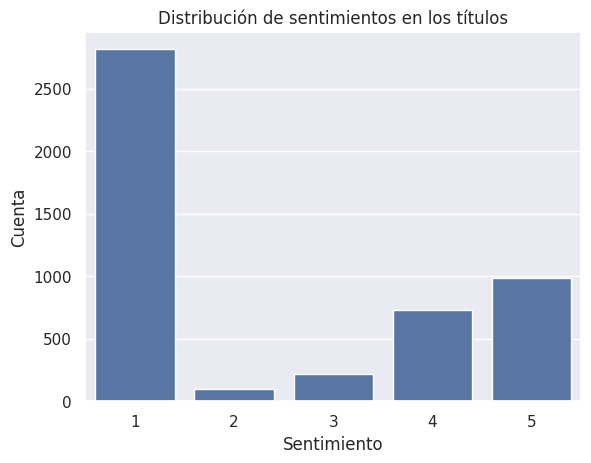

In [ ]:
sns.barplot(df_reduced['titleSentiment'].value_counts())

plt.xlabel('Sentimiento')
plt.ylabel('Cuenta')
plt.title('Distribución de sentimientos en los títulos')

plt.show()

La distribución de palabras tanto en el título como en el contenido del artículo indican que mayormente se busca atraer al lector con títulos cortos, de unas 10 a 14 palabras, ya que en la actualidad, el enfoque está en aumentar el "engagement" en redes sociales, necesitando un mayor tráfico de personas ingresando en las noticias, por lo que se requiere escribir con mayor simpleza y brevedad.

En cuanto a los artículos en sí, se puede decir que la distribución es más asimétrica, encontrándose en su mayoría artículos menores a 900 palabras, quizá aquellos que representan opiniones y no hechos puedan explicar este acontecimiento, ya que se requiere de menos palabras para indicar una postura personal, contra un hecho basado en fuentes diversas de información.

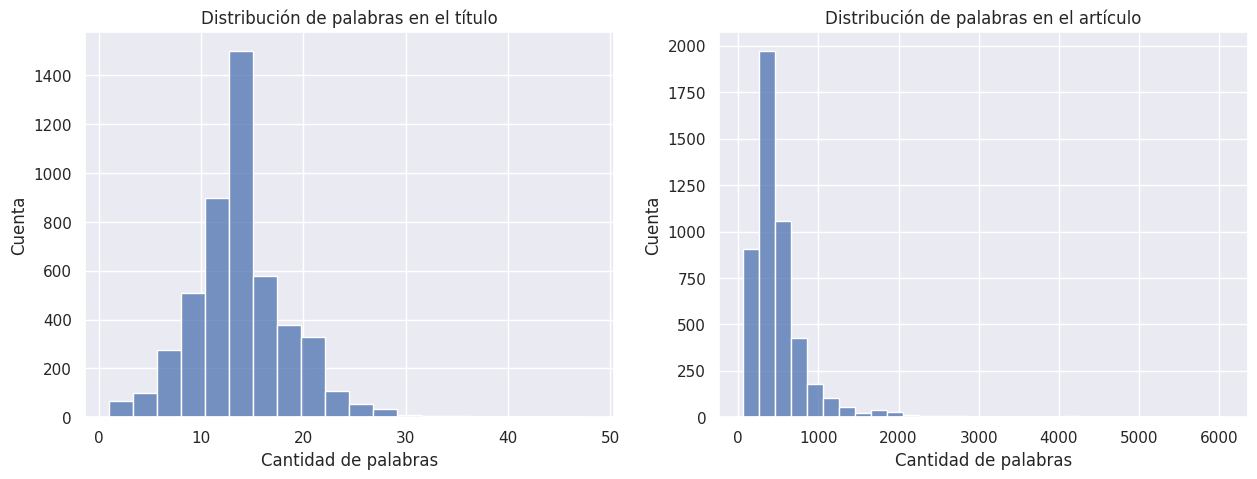

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_reduced['titleWords'], bins=20, ax=axs[0])
sns.histplot(df_reduced['bodyWords'], bins=30, ax=axs[1])

axs[0].set_title('Distribución de palabras en el título')
axs[1].set_title('Distribución de palabras en el artículo')

axs[0].set_xlabel('Cantidad de palabras')
axs[0].set_ylabel('Cuenta')
axs[1].set_xlabel('Cantidad de palabras')
axs[1].set_ylabel('Cuenta')

plt.show()

En la última gráfica se puede observar que la distribución de sentimientos respecto a la longitud del título es bastante similar en todo el espectro. Lo cual implica que no hay relación alguna entre una mayor cantidad de caracteres y algún sentimiento particular, ya que todos se encuentran equilibrados, a pesar de que el 5to valor del rango (el más positivo) se encuentra ligeramente por debajo de los demás, teniendo así en cuenta lo mencionado anteriormente sobre la actualidad del país.

Por otra parte, al poseer una mayor cantidad de caracteres el contenido del artículo, puede relacionarse con un sentimiento neutral-negativo, sin ser completamente concluyente. Esto podría deberse a que en muchos casos, se incluyen conversaciones u opiniones personales dentro de los artículos, y estos hacen uso de palabras más negativas en general.

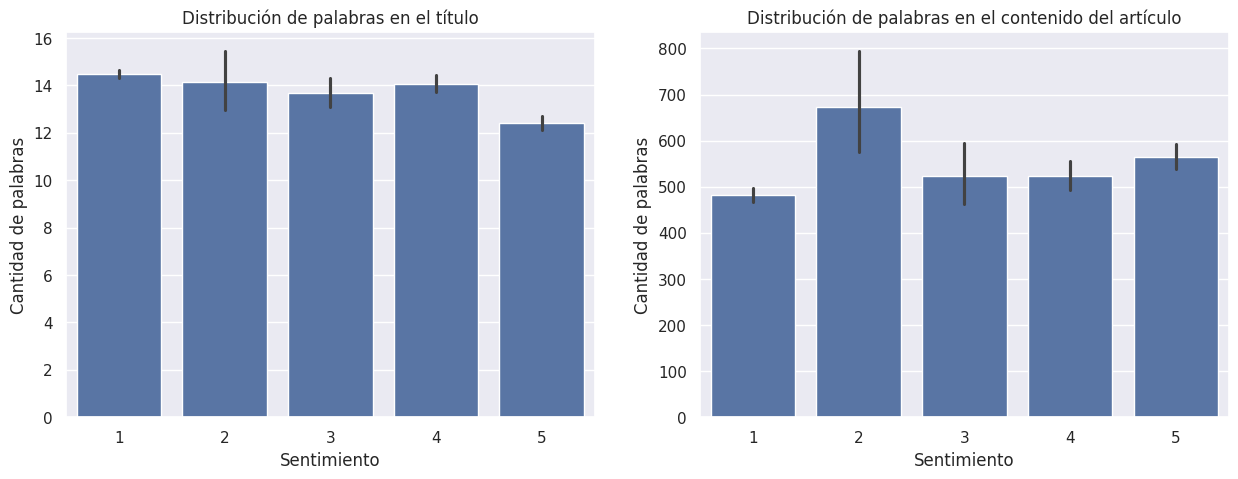

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=df_reduced, y='titleWords', x='titleSentiment', ax=axs[0])
sns.barplot(data=df_reduced, y='bodyWords', x='titleSentiment', ax=axs[1])

axs[0].set_title('Distribución de palabras en el título')
axs[1].set_title('Distribución de palabras en el contenido del artículo')

axs[0].set_xlabel('Sentimiento')
axs[0].set_ylabel('Cantidad de palabras')
axs[1].set_xlabel('Sentimiento')
axs[1].set_ylabel('Cantidad de palabras')

plt.show()

Por último, observamos en el análisis descriptivo del dataframe que el sentimiento global de los artículos ronda el valor de 2.3, lo cual es neutral-negativo, tal como se observó anteriormente.

El conteo de palabras en el título indica que el 75% de los artículos cuentan con 16 palabras o menos, lo que permite al lector inferir el contenido sin necesidad de ingresar al artículo completo.

El autor con mayor cantidad de artículos encontrados en este set de datos fue **semana.com** (entre otras 450 fuentes) con 185 artículos, lo cual podría ayudar a considerar dicha fuente como una bien valorada, recordando que los filtros de búsqueda fueron el ranking de Alexa y el de posteo en redes sociales, alcanzando un público mayor al de las demás fuentes de información.

In [ ]:
df_reduced.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,4847,34,2024-06-05,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataType,4847,3,news,4747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url,4847,4842,https://african.business/2024/06/politics/ghan...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,4847,4845,Colombia propone visados laborales circulares ...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,4847,4780,(CNN Español) -- En medio de la controversia p...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relevance,4847.0,NaN,NaN,NaN,5797362.222406,111075856.604081,0.0,0.0,419.0,21907.0,2147483647.0
author,4847,450,semana.com,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
titleSentiment,4847.0,NaN,NaN,NaN,2.377759,1.709103,1.0,1.0,1.0,4.0,5.0
titleWords,4847.0,NaN,NaN,NaN,13.953786,4.696344,1.0,11.0,14.0,16.0,48.0
bodyWords,4847.0,NaN,NaN,NaN,510.451207,434.924859,63.0,298.5,409.0,586.5,6058.0
